In [9]:
import pandas as pd, re, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
np.random.seed(42)

# Part 1 Pre-Processing

## Labeling Sample

| seq | text                                                                                                                                                         | label     |
|-----|--------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------|
| 74  | @116062: will you create a “disaster registry” where fire victims can pick the items they need and anyone can fill them? Offer discounts?                    | pricing   |
| 75  | "@AppleSupport Freezing basically all of the time. Apps are messing up, if i turn on airplane mode and then turn it off i can’t get service without restart" | technical |
| 76  | @VirginTrains I’ve lost my tkt back to Wilmslow. I’ve got receipt and it’s on my app but your staff tell me too bad. Surely not right??                      | technical |
| 77  | @AmazonHelp I ordered a package to be delivered tomorrow but I’ve had a notification saying it’ll be a day late now                                          | delivery  |
| 78  | "@AmazonHelp prime membership says it’s suspended, updated payment method but still says it’s suspended? How do I fix it to get Prime back?"                 | payment   |


### 这是弱标记数据
#### 使用 utils.py.auto_label_by_keywords 方法标注

In [2]:
df = pd.read_csv("../../assets/labeled_L2__bucket_sampled.csv")
df.head(10)

,tweet_id,text,label
0,1553020,@480508 @480507 @480506 @XboxSupport It worked...,technical
1,433087,UPDATE iOS 11.0.2 😤 iPHONE IS EXTREMELY SLOW N...,technical
2,2093386,@467250 Sorry for the inconvenience. Do you s...,technical
3,401610,@210972 I'm sorry for the trouble. Have you tr...,technical
4,326051,@193675 We're sorry that you are seeing errors...,technical
5,1278976,"@129201 Being a part of customer support, we'l...",technical
6,1039468,"can i ask, why would #Windows10FallCreatorsUpd...",technical
7,2035663,"@ATVIAssist Ummm, ok. The error pops up when i...",technical
8,1739395,@524944 Hi there. I regret the delay. Even wit...,technical
9,2596906,@AskPlayStation I’ve done everything and nothi...,technical


In [5]:
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"http\S+", "", txt)  # remove URLs
    txt = re.sub(r"@\w+", "", txt)  # remove @handles
    txt = re.sub(r"[^a-z\s]", " ", txt)  # keep only letters and spaces
    txt = re.sub(r"\s+", " ", txt).strip()  # collapse multiple spaces

    return txt

清洗读取进来的数据

In [6]:
df["clean_text"] = df["text"].astype(str).apply(clean_text)
df.head(10)

,tweet_id,text,label,clean_text
0,1553020,@480508 @480507 @480506 @XboxSupport It worked...,technical,it worked in the morning i just got home and a...
1,433087,UPDATE iOS 11.0.2 😤 iPHONE IS EXTREMELY SLOW N...,technical,update ios iphone is extremely slow now freezi...
2,2093386,@467250 Sorry for the inconvenience. Do you s...,technical,sorry for the inconvenience do you see any kin...
3,401610,@210972 I'm sorry for the trouble. Have you tr...,technical,i m sorry for the trouble have you tried delet...
4,326051,@193675 We're sorry that you are seeing errors...,technical,we re sorry that you are seeing errors what de...
5,1278976,"@129201 Being a part of customer support, we'l...",technical,being a part of customer support we ll be unab...
6,1039468,"can i ask, why would #Windows10FallCreatorsUpd...",technical,can i ask why would windows fallcreatorsupdate...
7,2035663,"@ATVIAssist Ummm, ok. The error pops up when i...",technical,ummm ok the error pops up when it try choose z...
8,1739395,@524944 Hi there. I regret the delay. Even wit...,technical,hi there i regret the delay even with the erro...
9,2596906,@AskPlayStation I’ve done everything and nothi...,technical,i ve done everything and nothing will work i v...


# Part 2 划分训练/测试集

In [27]:
from sklearn.preprocessing import LabelEncoder
# XGBClassifier 要求 y 是整数
le = LabelEncoder()
df["label_enc"] = le.fit_transform(df["label"])
print(df[['label', 'label_enc']])

X_tr, X_te, y_tr, y_te = train_test_split(
    df["clean_text"], df["label_enc"],
    test_size=0.2, stratify=df["label_enc"], random_state=42)

print("Train size :", len(X_tr), " | Test size: ", len(X_te))

# Train size : 5800  | Test size:  1450

          label  label_enc
0     technical          6
1     technical          6
2     technical          6
3     technical          6
4     technical          6
...         ...        ...
7245      legal          2
7246      legal          2
7247      legal          2
7248      legal          2
7249      legal          2

[7250 rows x 2 columns]
Train size : 5800  | Test size:  1450


# Part 3 定义TF-IDF -> XGBoost 基模型

In [25]:
base_xgb = make_pipeline(
    TfidfVectorizer(max_features=3000, stop_words="english"),
    XGBClassifier(
        objective="multi:softprob",
        num_class=y_tr.nunique(),
        n_estimators=250,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8, # 80% sample
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        n_jobs=-1,
        random_state=42
    )
)

In [29]:
# 手动 Bagging， 使用 BaggingClassifier报错 Expected 2d array, X_tr, y_tr 是 1d
# base_xgb = BaggingClassifier(
#     estimator=base_xgb,
#     n_estimators=10, # 10 个子模型
#     max_samples=0.8, # 每袋 80% 样本
#     bootstrap=True,
#     n_jobs=-1,
#     random_state=42
# )
# base_xgb.fit(X_tr, y_tr)


from collections import Counter

N_BAGS = 10
SAMPLES = 0.8
models = []
vecs = []

for i in range(N_BAGS) :
    # bootstrap 抽样
    idx = np.random.choice(len(X_tr), int(len(X_tr)*SAMPLES), replace=True)
    X_boot = X_tr.iloc[idx]
    y_boot_enc = y_tr.iloc[idx]

    # TF-IDF + XGB
    vec = TfidfVectorizer(max_features=3000, stop_words='english')
    X_boot_vec = vec.fit_transform(X_boot)

    clf = XGBClassifier(
        objective="multi:softprob",
        num_class=y_tr.nunique(),
        n_estimators=250, max_depth=5,
        learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
        eval_metric="mlogloss", n_jobs=-1, verbosity=0, random_state=42+i)
    clf.fit(X_boot_vec, y_boot_enc)
    models.append(clf)
    vecs.append(vec)

print("Done")

Done


# Part 3 指标评估

In [30]:
from scipy.stats import mode

def bag_predict(text_series):
    """
    text_series: pd.Series or list[str]
    返回 int 标签，和 y_tr 同编码
    """
    preds = [
        mdl.predict(vec.transform(text_series))
        for mdl, vec in  zip(models, vecs)
    ]

    preds = np.vstack(preds)

    vote_pred, _ = mode(preds, axis=0, keepdims=False)
    return vote_pred

              precision    recall  f1-score   support

     account       0.98      0.87      0.92        60
    delivery       0.92      0.99      0.96       420
       legal       1.00      0.78      0.87        40
     payment       0.99      0.96      0.97       300
     pricing       0.96      0.77      0.85        30
     service       0.92      0.97      0.95       240
   technical       0.98      0.94      0.96       360

    accuracy                           0.95      1450
   macro avg       0.96      0.90      0.93      1450
weighted avg       0.95      0.95      0.95      1450



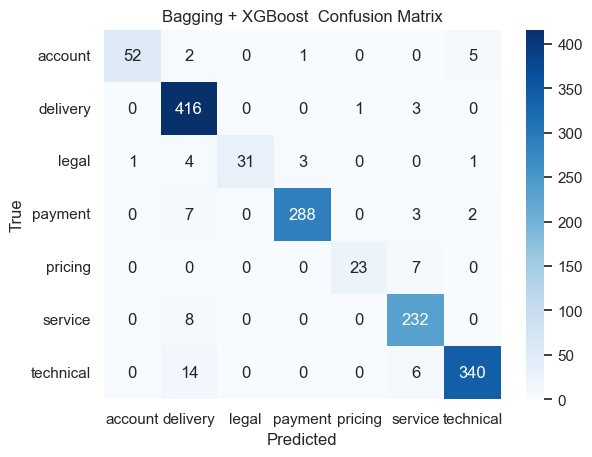

In [32]:
# 预测测试集
y_pred_enc = bag_predict(X_te) # INT
y_true_enc = y_te.values

# 标签
y_pred_lbl = le.inverse_transform(y_pred_enc)
y_true_lbl = le.inverse_transform(y_true_enc)

# precision / recall / f1
print(classification_report(y_true_lbl, y_pred_lbl))

# 混淆矩阵
cm = confusion_matrix(y_true_lbl, y_pred_lbl, labels=le.classes_)
# plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Bagging + XGBoost  Confusion Matrix")
plt.show()